In [2]:
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt 
from pythainlp.tokenize import word_tokenize
from pythainlp.corpus import thai_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from datetime import date
from wordcloud import WordCloud, STOPWORDS 

In [3]:
# Read chatlog data
chatlog = pd.read_pickle('./data/chatlog.p') 

In [4]:
# Format time to match with the data
today = date.today()
td = today.strftime("%Y-%m-%d")

In [7]:
# Clean the chatlog to have only user conversation on specific date
def clean_chatlog(chatlog, start_date:str=td, end_date:str=td):
    df = chatlog[['userId', 'message', 'role', '_date']] 
    df = df.loc[df.role=='User']
    return df[(df._date >= start_date) & (df._date <= end_date)]

In [8]:
df_new = clean_chatlog(chatlog, start_date='2019-11-01', end_date='2019-11-04')
df_new

,userId,message,role,_date
0,2433413723406579,สวัสดี,User,2019-11-01
3,2433413723406579,สวัสดีครับ,User,2019-11-01
6,2433413723406579,สวัสดีจ้า,User,2019-11-04
9,2433413723406579,ไม่ต้องยุ่งอ่ะ,User,2019-11-04
11,2433413723406579,ไม่ต้องมาคุย,User,2019-11-04
...,...,...,...,...
182231,2765986723444282,ถ้ารถผ่อนมั้ยหมดทีจะได้มั้ยค่ะ,User,2019-11-04
182234,2765986723444282,กุ้ค่ะ,User,2019-11-04
182239,2969967083016774,เปิดรับพนักงานไหมค่ะ,User,2019-11-04
182241,3050730068273826,รถมอไซยังส่งไปหมด,User,2019-11-04


In [6]:
# Utils
def get_th_tokens(text):
#     text = text.lower()
    text = text.replace('\n', ' ')
    text = text.replace(',', ' ')
    tokens = word_tokenize(text, engine="longest", keep_whitespace=False)
    return tokens

In [7]:
# Clean undesired text
def clean_text_1(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('[.?]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('[‘’“”…]', '', text)
    text = re.sub('\n', '', text)
    text = re.sub('[0-9]{1,10}', '', text)
    text = re.sub('นะ|น่ะ|น่า|น้า','',text)
    text = re.sub('คะ|ค่ะ|ค่า|คระ|คร่ะ|คร๊|ค๊|คร้า','',text)
    text = re.sub('ครับ|คับ|คั้บ|ค้าบ|คัฟ|คร้าบ|คาฟ|ค้าฟ|ฮะ|ฮับ|ฮ้าฟ','',text)
    text = re.sub('จ้า|จ้ะ|จ๊ะ','',text)
    text = re.sub('หน่อย|น่อย','',text)
    text = re.sub('สวัสดี|หวัดดี','',text)
    text = re.sub('ของ','',text)
    # ลบ text ที่อยู่ในวงเล็บ <> ทั้งหมด
    text = re.sub(r'<.?>','', text)
    # ลบ hashtag
    text = re.sub(r'#','',text)
    # ลบ separator เช่น \n \t
    text = ' '.join(text.split())
    text = re.sub('สนใจ','',text)
    text = re.sub('อยากทราบว่า|อยากทราบ','',text)
    text = re.sub('รบกวนสอบถาม|ขอสอบถาม|สอบถาม','',text)
    text = re.sub('ปี','',text)
    text = re.sub('ขอบคุณ','',text)
    text = re.sub('ขอโทษ|ขอโทด','',text)
    text = re.sub('ขอ','',text)
    text = re.sub('ชั้น','',text)
    text = re.sub('เท่าไร|เท่าไหร่|เท่าหรั่ย|เท่าใด|เท่ารัย','',text)
    return text

In [8]:
# def listToString(s):  

#     # Initialize an empty string 
#     str1 = " " 
      
#     return ("".join(s)) 

In [9]:
def remove_digits(text):
    output = re.sub(r'\d+', '', text)
    return output

In [10]:
def remove_emoji(string):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

In [11]:
# Create new column to store the required string for further process
def clean_text_full(df):
    df = df.groupby(['userId'])['message'].apply(','.join).reset_index()
    df['message'] = df['message'].apply(lambda x: clean_text_1(x))
    df['message'] = df['message'].apply(lambda x: remove_emoji(x))
    df['message'] = df['message'].apply(lambda x: remove_digits(x))
    return df

In [12]:
df_new = clean_text_full(df_new)
df_new

,userId,message
0,1186000531525260,วีออสเท่าใรคั
1,1217179911739736,ป​​ผม​วีโก้​แชมป์​​ประตู​
2,1326518720805322,ออนิว
3,1334390303260358,อยากกรณีจำนำเล่มทะเบียนรถยนต์ ต้องเปนผู้ครอบคร...
4,1343993022391031,
...,...,...
2139,3916518708373650,isuzudmax sxสุรินทร์ ตรีทศกุล
2140,3938375756188118,มอไซยังผ่อนไม่หมด กู้ได้ไหม
2141,4218233651525904,อีซูซุ​d​ max
2142,Ufe1c28d4b7399dce582e6f23c91db3a6,ผมเกี่ยวกับรายละเอียดอัตราดอกเบี้ยรถมอไซค์หนึ่ง


In [13]:
# find top 10 keywords that has the highest TF-IDF average score
def top_20_keywords(df):
    vectorizer = TfidfVectorizer(tokenizer=get_th_tokens, token_pattern=None, ngram_range=(1,2)) 
    vectorizer.fit(df['message']) 
    feat_clean = vectorizer.transform(df['message']) 
    feat_clean_array = feat_clean.toarray() 
    avg_tfidf = feat_clean_array.sum(axis=0) / np.count_nonzero(feat_clean_array,axis=0) 
    result_clean = pd.DataFrame() 
    result_clean['word'] = vectorizer.get_feature_names() 
    result_clean['avg_tfidf'] = avg_tfidf 
    return result_clean.sort_values('avg_tfidf', ascending=False).head(20) 

In [14]:
df_new = top_20_keywords(df_new)
df_new

,word,avg_tfidf
348,hondabrio,1.000000
502,misubishimisubishi,1.000000
809,toyotarevotoyoya,1.000000
18230,โตโยต้า ประกัน,0.841103
19754,ไม่ ไม่,0.821014
1384,การ ชำระ,0.786791
2074,คร้,0.785695
733,test,0.765067
9205,มา กา,0.759075
2528,งง รายละเอียด,0.757504


In [15]:
def gen_text_for_wordcloud(df):
    words = df['word']
    words_to_array = words.tolist()
    return (" ".join(words_to_array))

In [16]:
text = gen_text_for_wordcloud(df_new)
print(text)

hondabrio misubishimisubishi toyotarevotoyoya โตโยต้า ประกัน ไม่ ไม่ การ ชำระ คร้ test มา กา งง รายละเอียด วิริยะ มาสด้า หมด พย ถ้า ทำสัญญา คราบ เชค เบี้ย true toyotavogo ประกัน true ประกัน toyotavogo ประกัน ภัยัั


In [17]:
def gen_word_cloud(text):
    path = './font/THSarabunNew.ttf'
    wordcloud = WordCloud(font_path=path, width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10, colormap='coolwarm',regexp = r"[ก-๙a-zA-Z']+", random_state=1).generate(text) 
    # Plot the WordCloud image                        
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 

    plt.savefig('./WordCloud/keyword_{}.png'.format(td))
    

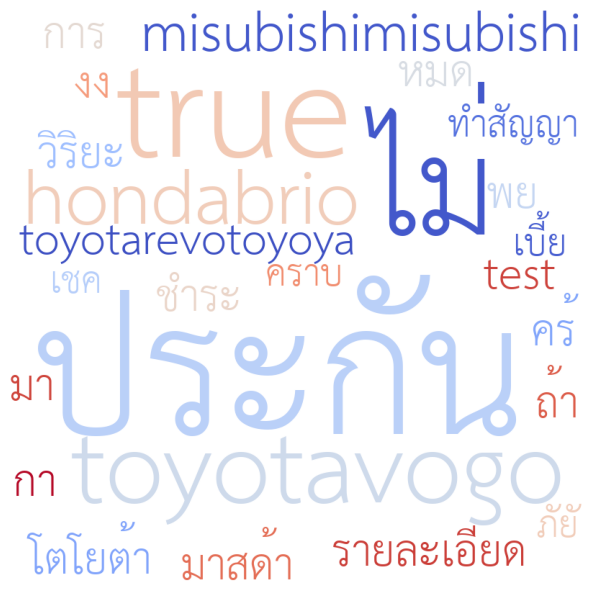

In [18]:
gen_word_cloud(text)

In [1]:
from sklearn.feature_extraction.text import CountVectorizer
# list of text documents
text = ["The quick brown fox jumped over the lazy dog."]
# create the transform
vectorizer = CountVectorizer()
# tokenize and build vocab
vectorizer.fit(text)
# summarize
print(vectorizer.vocabulary_)
# encode document
vector = vectorizer.transform(text)
# summarize encoded vector
print(vector.shape)
print(type(vector))
print(vector.toarray())

{'the': 7, 'quick': 6, 'brown': 0, 'fox': 2, 'jumped': 3, 'over': 5, 'lazy': 4, 'dog': 1}
(1, 8)
<class 'scipy.sparse.csr.csr_matrix'>
[[1 1 1 1 1 1 1 2]]
